# In this tutorial, we present Correlated Clustering and Projection (CCP) for visualizing single cell RNA sequencing (scRNA-seq) data.

We will begin by importing packages. Any recent versions of python, numpy, scikit-learn, umap-learn can be used to run the code. Please see the requirement.txt to reproduce the result from the paper.

In [42]:
from algorithm.auxilary import load_X, load_y, drop_sample
import matplotlib.pyplot as plt
from algorithm.cluster_accuracy import computeClusteringScore
import numpy as np
from algorithm.CCP_main import divide_features
from CCP.ccp import CCP

## Begin by loading the data. We will use GSE75748 cell data.

In [43]:
data = 'GSE75748cell'
data_process_path = './SingleCellDataProcess/'  #the location of where SingleCellDataProcess is located
data_path = './data/'  #location of where the processed raw data will be saved . If you have the data already processed, you can just set the file path here

X = load_X(data, data_path, data_process_path)
y = load_y(data, data_path, data_process_path)

X is the M by N matrix, where we have M genes and N cells

y is the labels, and is enumerated.

## We will do some preprocessing

Particularly, we will do a log transform, and drop cell types that have very few cells

In [44]:
min_cell = 15   #number of minimum cells per class
X = np.log10(1+X).T  #log transform and change the data to N by M
X, y = drop_sample(X, y, min_cell)


0 samples removed


## We will now partition the features according to their similarities. 
Set the cutoff for the low-variance gene, where the cutoff is the ratio of genes in the LV-genes. 

Additionally, select the number of components. CCP is stable at high dimension. We have tested in the range of 50-300 components, with a good performance. The last components will be the LV-gene

In [45]:
cutoff = 0.7        #LV-gene cutoff ratio
n_components = 250  #n_components
random_state = 1   #seed for dividing features

index_features = divide_features(X, 
                                 n_components = n_components, 
                                 cutoff = cutoff, 
                                 random_state = random_state)

print('Number of genes in the LV-gene: %d'%(len(index_features[-1])))

Number of genes in the LV-gene: 6291


## Running CCP
With the gene-partitioning completed, we can run CCP. CCP has 2 additional parameters, $\tau$ and $\kappa$, namely found from the generalized exponential function and lorentz function.

We have found that for CCP, $\tau = 6$ and $\kappa = 2$ are good choices for most data. The 'scale' parameter is $\tau$ and 'power' parameter is $\kappa$.

We have done extensive testing using the generalized exponential function, but any radial basis function will suffice. We have also implemented the lorentz function. Please select ktype = 'lor' for lorentz function.

We encourage users to vary these parameters for their work.

In [46]:
tau = 6
kappa = 2
myCCP = CCP(scale = tau, 
           power = kappa,
           ktype = 'exp')

In [47]:
X_ccp = myCCP.fit_transform(X, index_feature = index_features)  #any partition will work here


# Visualization
We will now visualize these results using UMAP and t-SNE

In [48]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [49]:
X_ccp_scaled = StandardScaler().fit_transform(X_ccp)  #scale if needed

In [50]:
myUMAP = UMAP(random_state = 1)
X_ccp_umap = myUMAP.fit_transform(X_ccp_scaled)

In [51]:
myTSNE = TSNE(random_state = 1)
X_ccp_tsne = myTSNE.fit_transform(X_ccp_scaled)

Text(0.5, 1.0, 'CCP-tSNE')

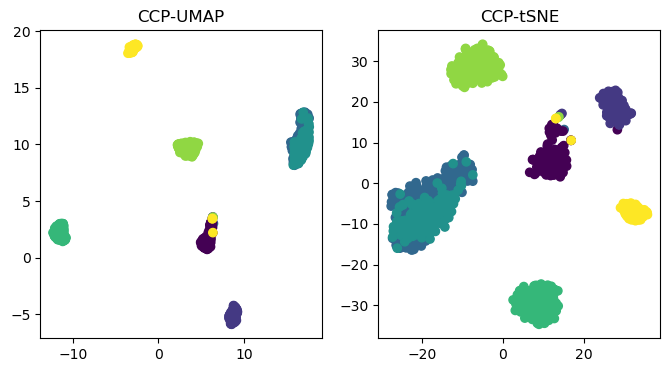

In [52]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].scatter(X_ccp_umap[:, 0], X_ccp_umap[:, 1], c = y)
ax[1].scatter(X_ccp_tsne[:, 0], X_ccp_tsne[:, 1], c = y)
ax[0].set_title('CCP-UMAP')
ax[1].set_title('CCP-tSNE')